In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.append("..")
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
params={'xtick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi']=200

In [3]:
class NeuralNet_A2C(Model):
    # This defines two distinct models
    # One is an actor, another is the critic (value function estimation)
    # Both are fully connected neural networks

    def __init__(self, input_dim=70, dim_actions=6, num_hidden_nodes_1=128,
                 num_hidden_nodes_2=64,
                 actor_lr=0.001, critic_lr=0.002, lstm = False):
        self.num_hidden_nodes_1 = num_hidden_nodes_1
        self.num_hidden_nodes_2 = num_hidden_nodes_2
        self.input_dim = input_dim
        self.dim_actions = dim_actions
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.initializer = tf.keras.initializers.glorot_uniform(seed = np.random.randint(0,50))
        self.lstm = lstm

        super(NeuralNet_A2C, self).__init__()
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.actor.optimizer = tf.keras.optimizers.Adam(learning_rate=self.actor_lr)
        self.critic.optimizer = tf.keras.optimizers.Adam(learning_rate=self.critic_lr)

    def build_actor(self):
        actor = Sequential()
        actor.add(layers.Input(shape=(self.input_dim)))
        actor.add(layers.Conv1D(64, kernel_size=(7), activation = tf.nn.relu, kernel_initializer=self.initializer))
        actor.add(layers.Conv1D(32, kernel_size=(3), activation = tf.nn.relu, kernel_initializer=self.initializer))
        actor.add(layers.AveragePooling1D(2))
        actor.add(layers.Flatten())
        actor.add(layers.Dense(self.num_hidden_nodes_1, activation=tf.nn.relu,
                               kernel_initializer=self.initializer,
                               name='fc_1'))
        actor.add(layers.Dense(self.num_hidden_nodes_2, activation=tf.nn.relu,
                               kernel_initializer=self.initializer, name='fc_2'))

        actor.add(layers.Dense(self.dim_actions * 2, activation='sigmoid',
                               kernel_initializer=self.initializer,
                               name='output_actions_layer'))

        # here the actor will output a mean, standard deviation from which we will sample.

        return actor

    def build_critic(self):
        # critic neural network
        critic = Sequential()
        critic.add(layers.Input(shape=(self.input_dim)))
        critic.add(layers.Conv1D(64, kernel_size=(7), activation = tf.nn.relu, kernel_initializer=self.initializer))
        critic.add(layers.Conv1D(32, kernel_size=(3), activation = tf.nn.relu, kernel_initializer=self.initializer))
        critic.add(layers.AveragePooling1D(2))
        critic.add(layers.Flatten())
        critic.add(layers.Dense(128, activation=tf.nn.relu,
                                kernel_initializer=self.initializer,
                                name='fc_1'))
        critic.add(layers.Dense(64, activation=tf.nn.relu,
                                kernel_initializer=self.initializer, name='fc_2'))
        critic.add(layers.Dense(1, activation='linear',
                                kernel_initializer=self.initializer,
                                name='output_actions_layer'))

        return critic

    # define forward pass
    def call(self, states):
        actions_output = self.actor(states)*3
        value_estimate = self.critic(states)

        return actions_output, value_estimate



In [4]:
#model for dynamics environment
class WallNet(Model):

    def __init__(self, input_dims = [14,2], output_dims=[12]):

        self.initializer =  tf.keras.initializers.he_uniform(seed = np.random.randint(0,50))
        self.input_dims = input_dims
        self.output_dims = output_dims
        super(WallNet, self).__init__()
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.RMSprop()

    def build_model(self):
        InputImage = layers.Input(shape=(self.input_dims[0],1))
        InputNumeric = layers.Input(shape=(self.input_dims[1]))
        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputImage)

        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)

        cnet = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)


        cnet = layers.Flatten()(cnet)

        cnet = Model(inputs=InputImage, outputs=cnet)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputNumeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = Model(inputs=InputNumeric, outputs=numeric)

        combined = layers.concatenate([cnet.output, numeric.output])

        x = layers.Dense(512,activation=tf.nn.relu, kernel_initializer=self.initializer)(combined)
        x = layers.Dense(256,activation=tf.nn.relu, kernel_initializer=self.initializer)(x)
        combined_network = layers.Dense(self.output_dims[0],activation='linear',
                                        kernel_initializer=self.initializer)(x)

        model = Model(inputs=[cnet.input, numeric.input], outputs=combined_network)

        return model

    # define forward pass
    def call(self, inputs):
        prediction = self.model(inputs)[:,:]

        return prediction

In [5]:
class WallEnv:
  def __init__(self, noise_val = 0.01,
               state_size=128, max_steps = 50,
               reward_freq = 'end', desired_wall = None,
               model_file=None):

    #reward_freq = 'all' or 'end'
    self.model_file = model_file
    self.ynet = WallNet()
    self.ynet.compile()
    self.ynet.model.load_weights(self.model_file)

    self.state_size = state_size
    self.noise_val = noise_val
    self.max_steps = max_steps
    self.reward_freq = reward_freq
    self.state = np.zeros(self.state_size) + np.random.normal(size=self.state_size, scale=self.noise_val)
    self.step_num = 0
    self.offset = 5
    self.local_win_size = 7
    self.local_state_size = 14
    self.done = False

    if desired_wall is not None:
      self.desired_wall = desired_wall
    else:
      desired_wall = np.zeros(self.state_size)
      desired_wall[:self.state_size//4] = 1.0
      desired_wall[self.state_size//4:self.state_size//2] = 0.75
      desired_wall[self.state_size//2:(self.state_size//4)*3] = 0.5
      desired_wall[((self.state_size//4)*3) :] = 0.25
      self.desired_wall = desired_wall

  def reset(self):
    init_steps = 20
    new_state = np.zeros(self.state_size) + np.random.normal(size=self.state_size, scale=self.noise_val)

    '''for i in range(init_steps):
        actions = np.random.randn(3)
        actions = np.clip(actions, 0.1, 0.9)
        actions[1] = (actions[1]*2)-1 #voltage distribution shift
        wall_pos = actions[0]*128+self.offset
        state_subsection = new_state[int(wall_pos-self.local_win_size): int(wall_pos+self.local_win_size)]
        model_state = np.array(state_subsection)
        model_state = tf.convert_to_tensor(model_state)
        model_state = model_state[None,:,None]
        model_actions = np.array(actions[1:])[None,:]
        model_actions = tf.convert_to_tensor(model_actions)
        model_input = [model_state, model_actions]
        wall_pred = self.ynet(model_input)
        wall12 = state_subsection[(self.local_win_size - (self.local_win_size-1)): (self.local_win_size + (self.local_win_size-1))]
        new_wall = wall12+wall_pred
        begin = int(wall_pos - (self.local_win_size-1))
        end = int(wall_pos + (self.local_win_size-1))
        new_state[begin:end]=new_wall'''

    self.state = new_state
    reward = self.get_reward(new_state)
    self.step_num = 0
    self.done = False
    return self.state, reward

  def step(self, action, verbose=False):

    if verbose: print("ACTIONS: ",action)
    #action has three values, first value is position, second is bias amp. third is pulse width
    #The first one is used to determine the sub-section of the state
    wall_pos = action[0]*128 + self.offset
    if verbose:
      print("FULL WALL: ", self.state)
      print("EXACT WALL POSITION: ", int(wall_pos))
    self.state_subsection = self.state[int(wall_pos - self.local_win_size): int(wall_pos + self.local_win_size)]
    if verbose: print("LOCAL WALL: ", self.state_subsection)

    model_state= np.array(self.state_subsection)
    model_state = tf.convert_to_tensor(model_state)
    model_state = model_state[None,:,None]
    model_actions= np.array(action[1:])
    model_actions = model_actions[None,:]
    model_actions = tf.convert_to_tensor(model_actions)
    if verbose:
      print('model_state is {} and model_actions is {}'.format(model_state, model_actions))

    model_input = [model_state, model_actions]
    wall_pred = self.ynet(model_input)
    wall12 = self.state_subsection[(self.local_win_size - (self.local_win_size-1)): (self.local_win_size + (self.local_win_size-1))]
    new_wall = wall12 + wall_pred
    new_state = np.copy(self.state)
    begin = int(wall_pos - (self.local_win_size-1))
    end =   int(wall_pos + (self.local_win_size-1))

    new_state[begin: end] = new_wall
    info = {}
    self.state = new_state
    self.step_num+=1
    cur_reward = -mean_squared_error(new_state,self.desired_wall)
    if self.step_num>=self.max_steps: self.done = True
    else: self.done = False

    done = self.done
    reward = self.get_reward(new_state)


    return new_state, reward, done, info

  def get_reward(self, my_state):
    if self.reward_freq == 'end':
      if self.done == False:
        reward=0
      else:
        reward = -mean_squared_error(my_state,self.desired_wall)

    elif self.reward_freq == 'all':
      reward = -mean_squared_error(my_state,self.desired_wall)

    return reward


In [6]:
def smooth_window(data, window_size):
    return np.convolve(data, np.ones((window_size,))/window_size, mode='valid')

In [7]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
training_hist = np.load('1/training_history.npy')


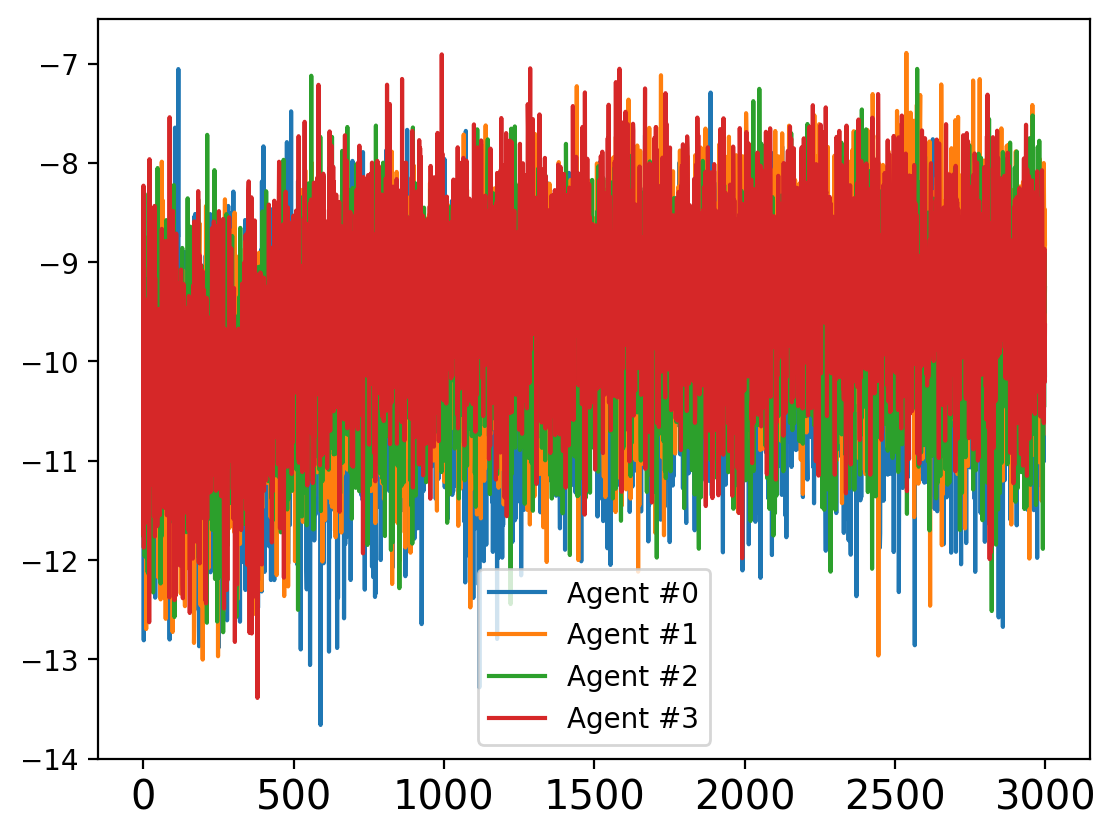

In [9]:
plt.figure()
for ind in range(training_hist.shape[-1]):
    plt.plot((training_hist[:,ind]), label = 'Agent #' + str(ind))
plt.legend(loc='best')

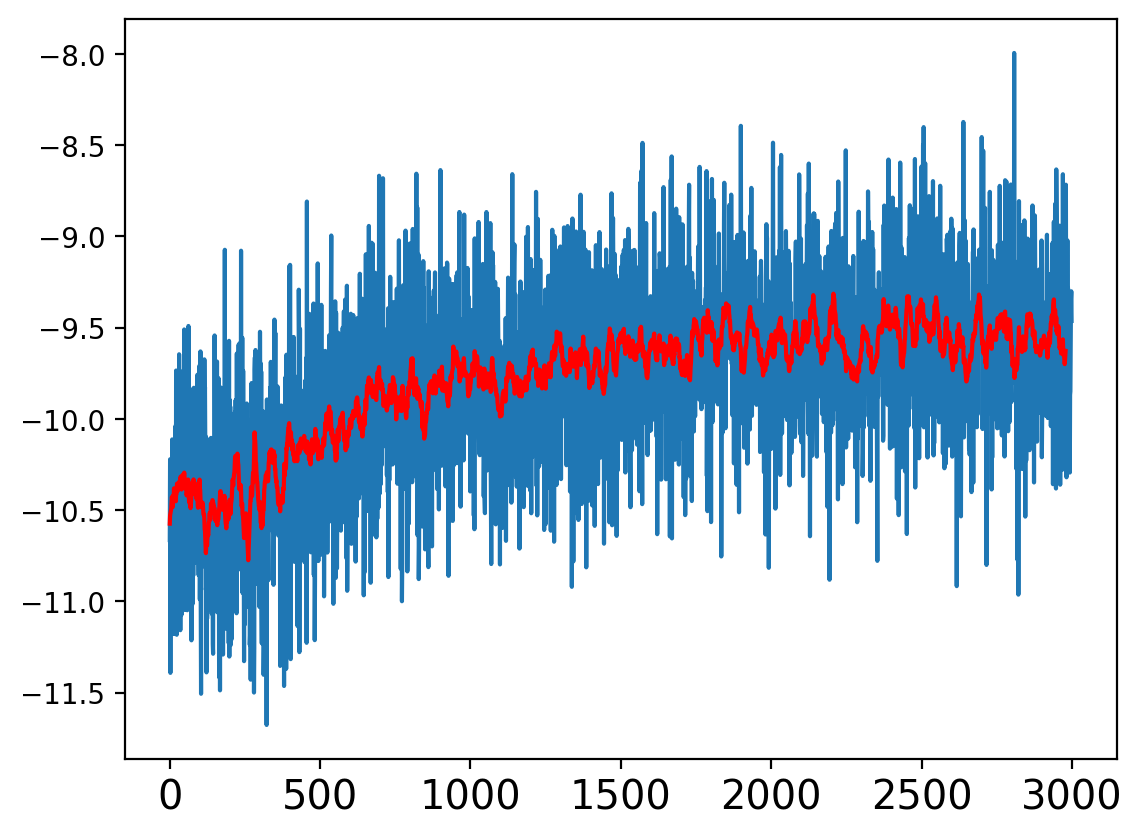

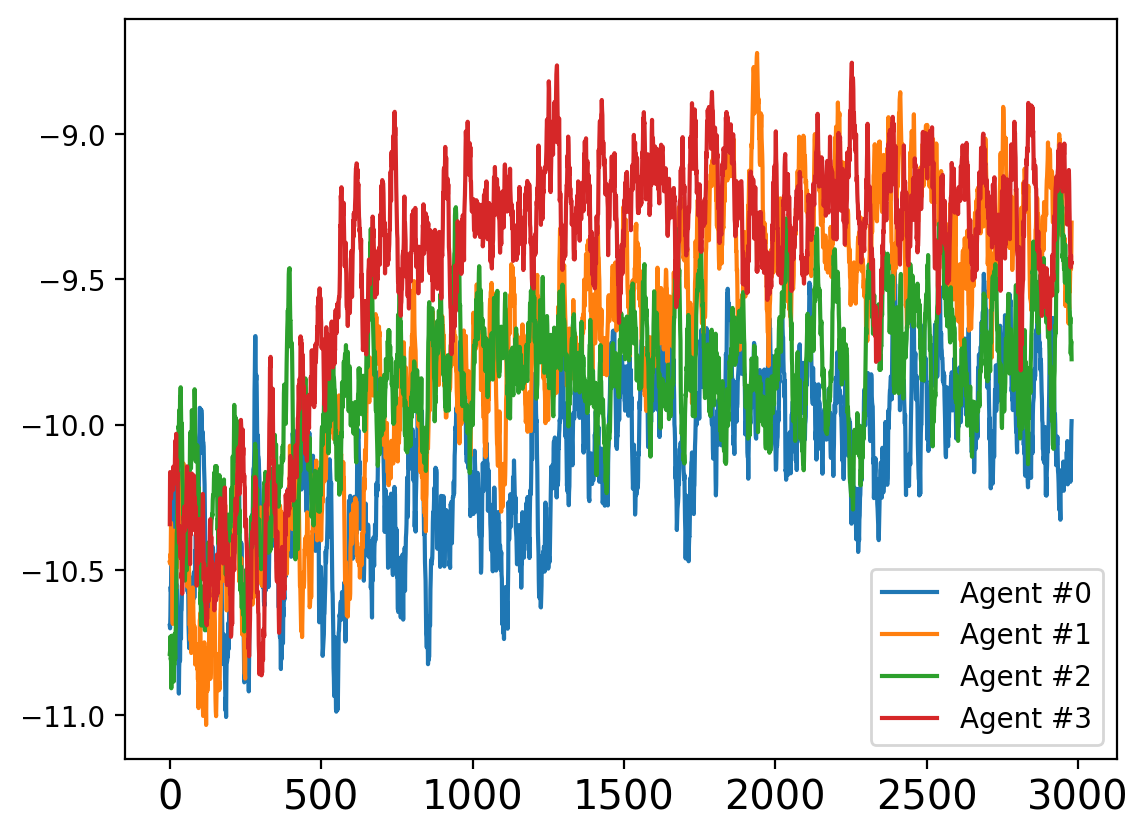

In [10]:
plt.figure()
plt.plot(training_hist.mean(axis=-1)[:])
plt.plot(smooth_window(training_hist.mean(axis=-1), 21), 'r-')

plt.figure()
for ind in range(training_hist.shape[-1]):
    plt.plot(smooth_window(training_hist[:,ind], 21), label = 'Agent #' + str(ind))
plt.legend(loc='best')

In [11]:
#Load actor and environments
ep_number = (len(training_hist)-1)
model_file = r'1/trained_weights_5_12.h5'
actor_file = '1/Actor_0_ep_{}.h5'.format(ep_number)
#actor_file = 'actor_73_reward=-0.0326.h5'
INS_Env = WallEnv(model_file = model_file)

policy = NeuralNet_A2C(input_dim=(128,1), dim_actions=3, actor_lr = 0.0001, critic_lr = 0.0002)
policy.actor.load_weights(actor_file)

In [12]:
final_states, final_rewards = [], []
num_trials = 10
initial_states = []
for _ in range(num_trials):
    actions_history, state_history, reward_history = [], [], []

    state,_ = INS_Env.reset()
    initial_states.append(state)
    reward_total = 0
    done = False

    while not done:

        actions_output, _ = policy(state[None,:, None])

        actions_output = tf.reshape(actions_output[0, :], (-1, 2))

        # Sample the policy to get the action
        output_action = tfp.distributions.MultivariateNormalDiag(
            tf.nn.softplus(actions_output[:, 0]), tf.nn.softplus(actions_output[:, 1])).sample(1)

        output_actions = np.squeeze(tf.clip_by_value(output_action, 0.1, 0.9).numpy())
        output_actions[1] = (output_actions[1]*2)-1           #need to shift from 0-1 to -1-1
        # Take the selected action in the environment
        next_state, reward, done, _ = INS_Env.step(output_actions)

        actual_reward = reward
        reward_total += actual_reward

        next_state = np.squeeze(next_state)

        # Save results
        actions_history.append(output_actions)

        #actions_history.append(output_action.numpy()[0])
        state_history.append(state.flatten())
        reward_history.append(reward)

        # First up, the actor network
        state = next_state.flatten()

    final_states.append(state)
    final_rewards.append(reward)

In [13]:
positions = []
for i in range(len(actions_history)):
    pos=actions_history[:][i][0]
    pos=pos*128
    positions.append(pos)

colors = []
for i in range(50):
    c = i
    colors.append(c)

colors = np.array(colors)

Text(0.5, 0, 'Voltage (V)')

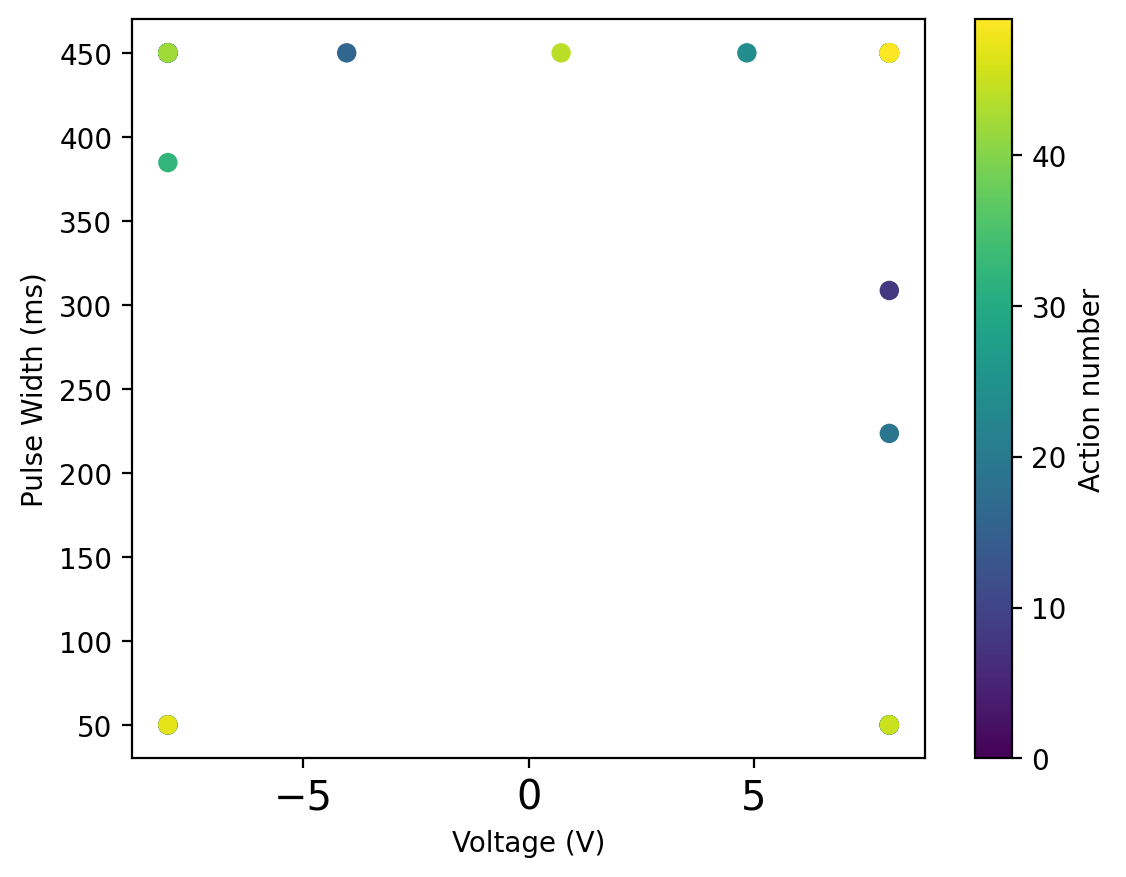

In [14]:
v_ = []
pw_ = []
for i in range(len(actions_history)):
    v = actions_history[:][i][1]*10
    p = actions_history[:][i][2]*500
    pw_.append(p)
    v_.append(v)

plt.scatter(v_,pw_,c=colors, cmap='viridis')
plt.colorbar(label='Action number')

plt.ylabel("Pulse Width (ms)")
plt.xlabel("Voltage (V)")

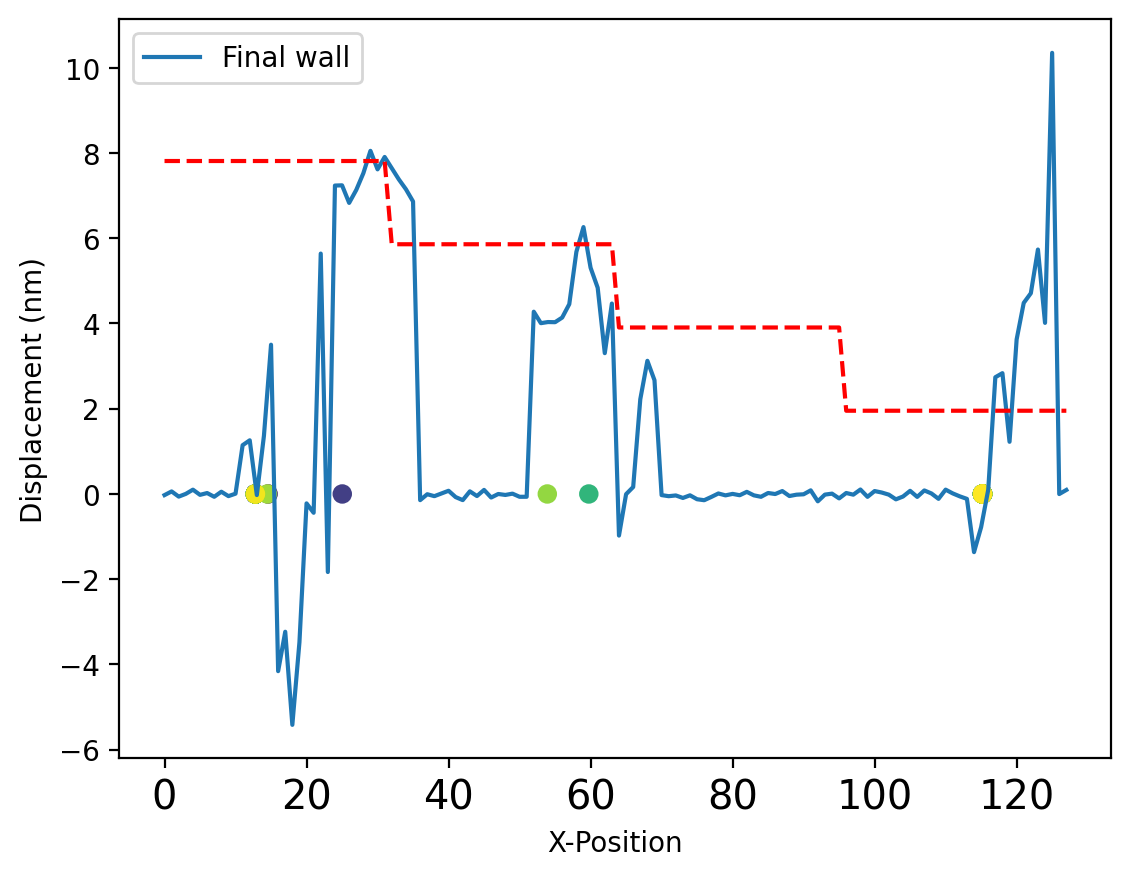

In [15]:
plt.figure()
plt.plot(np.array(final_states).T[:,-1]*7.8125, label='Final wall')
plt.scatter(positions,np.zeros(50), c=colors, cmap='viridis')
plt.plot(INS_Env.desired_wall*7.8125, 'r--')
plt.ylabel("Displacement (nm)")
plt.xlabel("X-Position")
#plt.plot(initial_states[-1]*7.8125, label="Inital wall")
plt.legend()